# **Rum Recommender System with Graph Neural Networks using PyG**

## Introduction

This is a main notebook for the tutorial on applying state-of-the-art graph ML to develop recommender system using the powerful PyG library.

In today's digital age, personalized recommendations have become crucial for users to navigate through the vast sea of content that surrounds them. Whether it finds the perfect dish to try or discovers the next great book to read, a well-designed recommender system can make all the difference.

And that's where graph ML comes into play. It unlocks new possibilities, allowing us to leverage the data interconnections to create intelligent and tailored recommendations. In this tutorial, we will focus on implementing the LightGCN model for recommending rum and whiskey products for users using PyG.

## Credits

This project is a part of the core course on Data and Knowledge Representation at Innopolis University.

It is a collaborative effort by our team including:

- Leila Khaertdinova, l.khaertdinova@innopolis.university, *BS21-DS-02*
- Karina Denisova, k.denisova@innopolis.university, *BS21-DS-01*
- Ivan Chernakov, i.chernakov@innopolis.university, *BS21-DS-02*




# Device
For implementing graph neural networks (GNNs), it is recommended to use a GPU for training. So, in this colab, please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

In [1]:
import torch

print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.1.0+cu121


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Required setup

For GNN construction, we will use PyTorch Geometric ([PyG](https://pytorch-geometric.readthedocs.io/)) library. This is a PyTorch extension library for geometric deep learning, which consists of a variety of methods and utilities to ease the implementation of graph neural networks.

In [3]:
# Install torch geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-{torch.__version__}.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.0 MB/s eta 0:00:00


In [4]:
import torch_geometric
print("PyG has version {}".format(torch_geometric.__version__))

PyG has version 2.4.0


# Imports

In [5]:
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

import seaborn as sns
import matplotlib.pyplot as plt

# Data prepocessing

## Dataset description

In this tutorial, we are using a real data that we crawled from the [Distiller website](https://distiller.com/) thas is liquor online store with real users and their ratings on the purchased products. The crawling process can be checked in this [Colab notebook](https://colab.research.google.com/drive/1iO_XRAxQ2A5M-Pe-wpcAVW9YCINV93up?usp=sharing).

You can access an intermidiate dataset from our [repository](https://github.com/karinaDen/Rum-Recommendation/tree/main) in the `data/interim` folder.

The dataset consists of the following columns:
- `username` — username of the user who has purchased and rated the rum product;
- `item` — name of the rum/whiskey that has been rated;
- `rating` — rating score given by the user for the rum they have purchased;
- `user_id` — id of a user;
- `item_id` — id of a product.

To ensure the dataset's reliability, each user has provided ratings for a minimum of 10 items.


## Our goal

Our focus is to analyze past user-rum interactions, specifically considering user ratings. Thus, we can model the recommender system as a bipartite graph, with user and rum item types of nodes connected by edges representing user rating scores. This approach enables us to utilize graph ML techniques to recommend new rum or whiskey products to users in the future.

In [6]:
!git clone https://github.com/karinaDen/Rum-Recommendation.git

Cloning into 'Rum-Recommendation'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 17 (delta 4), reused 12 (delta 2), pack-reused 0
Receiving objects: 100% (17/17), 1.70 MiB | 13.57 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [7]:
ds = pd.read_csv('Rum-Recommendation/data/interim/reviews_final.csv')
ds.head()

,username,item,rating,user_id,item_id
0,00PJ00,ardbeg-corryvreckan,5.00,1,19
1,00PJ00,ardbeg-uigeadail,4.00,1,22
2,00PJ00,benromach-peat-smoke-2005,4.00,1,55
3,00PJ00,elijah-craig-12,4.25,1,155
4,00PJ00,gooderham-worts-four-grain-canadian-whisky,4.75,1,217


The length of the dataset is the number of user-item interactions.

In [8]:
print(f'Dataset length: {len(ds)}')

Dataset length: 31783


The `item_names_and_ids` will be used later to display the names of the recommended items during the inference phase.

In [9]:
item_names_and_ids = ds[['item_id', 'item']].drop_duplicates()
print('Item id and item name:')
item_names_and_ids.head()

Item id and item name:


,item_id,item
0,19,ardbeg-corryvreckan
1,22,ardbeg-uigeadail
2,55,benromach-peat-smoke-2005
3,155,elijah-craig-12
4,217,gooderham-worts-four-grain-canadian-whisky


In order to predict which rum/whiskey products a user may try in the future, we will only consider high ratings (specifically, rating scores above 3.25) as interactions.

In [10]:
# Filter the dataset to include only high ratings (above 3.25)
ds = ds[ds['rating'] > 3.25]

print(f'Filtered dataset length: {len(ds)}')

Filtered dataset length: 28131


In [11]:
print('Rating distribution:')
ds['rating'].value_counts().sort_index(ascending=False)

Rating distribution:


5.00    7950
4.75    1622
4.50    3801
4.25    3197
4.00    8930
3.75    1515
3.50    1116
Name: rating, dtype: int64

Now, let's split the dataset with a 80/20 train-test ratio.

In [12]:
train, test = train_test_split(ds.values, test_size=0.2, random_state=42)

train_ds = pd.DataFrame(train, columns=ds.columns)
test_ds = pd.DataFrame(test, columns=ds.columns)

print(f'Train dataset length: {len(train_ds)}')
print(f'Test dataset length: {len(test_ds)}')

Train dataset length: 22504
Test dataset length: 5627


Due to the randomness of interactions train-test split, it is possible that not all users and items are present in the training set. To address this, we will relabel all users and items to ensure that the highest label corresponds to the total number of users and items, respectively.

In [13]:
encoder_1 = LabelEncoder()
train_ds['user_id_idx'] = encoder_1.fit_transform(train_ds['user_id'].values)

encoder_2 = LabelEncoder()
train_ds['item_id_idx'] = encoder_2.fit_transform(train_ds['item_id'].values)

train_user_ids = train_ds['user_id'].unique()
train_item_ids = train_ds['item_id'].unique()

In [14]:
test_ds.loc[test_ds['user_id'].isin(train_user_ids), 'user_id_idx'] = \
    encoder_1.transform(test_ds.loc[test_ds['user_id'].isin(train_user_ids), 'user_id'].values)

test_ds.loc[test_ds['item_id'].isin(train_item_ids), 'item_id_idx'] = \
    encoder_2.transform(test_ds.loc[test_ds['item_id'].isin(train_item_ids), 'item_id'].values)

In [15]:
num_users = len(train_user_ids)
num_items = len(train_item_ids)

print(f'Unique users count: {num_users}')
print(f'Unique rum items count: {num_items}')

Unique users count: 1713
Unique rum items count: 505


## Edge Index

In PyG, graphs are represented as sparse lists of node pairs. As our graph is undirected, we need to include each edge twice - once for the edges from the users to the items, and once for the edges from the items to the users.

In [16]:
users_t = torch.LongTensor(train_ds['user_id_idx'])
items_t = torch.LongTensor(train_ds['item_id_idx']) + num_users

edge_index = torch.stack((torch.cat([users_t, items_t]), torch.cat([items_t, users_t])))
edge_index = edge_index.to(device)

edge_index

tensor([[ 177,   48,  925,  ..., 2035, 2085, 2121],
        [2088, 1798, 2207,  ...,   56,  980, 1456]], device='cuda:0')

# LightGCN Implementation

## Model Description

LightGCN model is a type of graph neural network architecture that is widely used for recommendation tasks. It only utilizes the initial node embeddings of users and items in the graph as trainable parameters.

The main concept behind LightGCN is to propagate embeddings across the graph by aggregating information from neighboring nodes. This is done by updating node embeddings based on the embeddings of their neighboring nodes.

The LightGCN architecture operates based on the following set of rules:

$$e_{u}^{(k+1)} = \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}e^{(k)}_i$$

$$e_{i}^{(k+1)} = \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}e^{(k)}_u$$

Additionally, the each node embedding after a single LightGCN layer is the sum of the synthetic normalized embeddings of it's neighbors before the layer.

The following code snippet implements the LightGCN convolutional layer using PyG. Notice that we are using the `MessagePassing` class that is a base class for implementing message passing layers.

In [17]:
class LightGCNConv(MessagePassing):
    def __init__(self, **kwargs):
        super().__init__(aggr='add')

    def forward(self, x, edge_index):
        # Propagate messages (no update after aggregation)
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # Apply normalization to the neighbor features
        return norm.view(-1, 1) * x_j

# Recommender System Model Implementation

In this tutorial, we are using the following class **RecSys** in order to stack the LightGCN convolutional layer.

You can make certain adjustments to our model by considering the **number of layers** and **dimension of latent space**. Increasing the number of layers in the model results in a broader dissemination of recommendation information from nodes that are **n** hops away in a model with **n** layers.

It's important to observe that our forward function operates differently compared to typical neural networks, as it performs forward propagation of embeddings for all nodes in the graph. This is necessary because the embeddings of a specific node rely on the embeddings of its **n**-hop neighborhood, thus requiring their propagation as well.

In [18]:
class RecSys(nn.Module):

    def __init__(self, lat_dim, num_layers, num_users, num_items):
        super(RecSys, self).__init__()

        self.embedding = nn.Embedding(num_users + num_items, lat_dim)
        self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))
        self.init_parameters()

    def init_parameters(self):
        # Authors in [1] mentioned the higher results with normal initialization
        nn.init.normal_(self.embedding.weight, std=0.1)

    def forward(self, edge_index):
        # Compute initial embeddings
        init_embed = self.embedding.weight
        embeds = [init_embed]

        # Compute final embeddings
        final_embed = init_embed
        for conv in self.convs:
            final_embed = conv(x=final_embed, edge_index=edge_index)
            embeds.append(final_embed)
            output = torch.mean(torch.stack(embeds, dim=0), dim=0)

        return init_embed, output

    def encode(self, users, positive, negative, edge_index):
        # Encode minibatch of users, positive items and negative items
        init_embed, output = self(edge_index)
        return (output[users], output[positive], output[negative],
                init_embed[users], init_embed[positive], init_embed[negative])


## Minibatch Sampling

To train our model effectively, we need to sample minibatches consisting of users, positive and negative items. This can be achieved by first sampling users and then, for each user, sampling both positive and negative items.

In [19]:
def sample_negative_items(list_):
    # sample a negative item that is not in the given list
    while True:
        negative_id = random.randint(0, num_items - 1)
        if negative_id not in list_:
            return negative_id

def sample_minibatch(ds, batch_size, num_users, num_items):
    # Group the dataset by user ID and create a new dataset
    new_ds = ds.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [idx for idx in range(num_users)]

    # Sample users for the minibatch
    if num_users < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_t = torch.LongTensor(list(users))
    users_ds = pd.DataFrame(users, columns = ['users'])

    # Merge the new dataset with the sampled users
    result_ds = pd.merge(new_ds, users_ds, how='right', left_on='user_id_idx', right_on='users')

    # Sample positive items for the users
    positive_items = result_ds['item_id_idx'].apply(lambda x : random.choice(x)).values
    positive_items_t = torch.LongTensor(list(positive_items))

    # Sample negative items for the users
    negative_items = result_ds['item_id_idx'].apply(lambda x: sample_negative_items(x)).values
    negative_items_t = torch.LongTensor(list(negative_items))

    return (users_t.to(device),
            positive_items_t.to(device) + num_users,
            negative_items_t.to(device) + num_users)

## Loss function

We use the Bayesian Personalized Ranking (BPR) loss function for a single minibatch of users, positive items and negative items. It aligns better with the recall@k metric.

The formula of BPR loss for a user $u$ is the following:

$$BPR(u) = \frac{1}{|E|⋅|E_{neg}|}\sum\limits_{{(u, v_{pos})} \in E(u)}\sum\limits_{{(u, v_{neg})} \in E_{neg}(u)}-log(\sigma(f_{\theta}(u, v_{pos}) - f_{\theta}(u, v_{neg})))$$
Then, the loss is normalized across all users.

More precisely, the BPR [[2]](https://arxiv.org/ftp/arxiv/papers/1205/1205.2618.pdf) is a pairwise ranking loss function that aims to maximize the difference between the scores of positive and negative items for each user. This is done by minimizing the negative log likelihood of the positive items' scores.

In [20]:
def get_bpr_loss(users, users_embed, pos_embed, neg_embed, user_init_embed,
                     pos_init_embed, neg_init_embed):

    # Compute regulization loss from initial embeddings
    reg_loss = 0.5 * (user_init_embed.norm().pow(2) +
                      pos_init_embed.norm().pow(2) +
                      neg_init_embed.norm().pow(2)) / float(len(users))

    # Compute BPR loss from user, positive item and negative item embeddings
    pos_scores = torch.mul(users_embed, pos_embed).sum(dim=1)
    neg_scores = torch.mul(users_embed, neg_embed).sum(dim=1)
    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    # Return both regularization loss and BPR loss
    return reg_loss, bpr_loss

## Evaluation Metric

The recall@k metric is a commonly used evaluation metric in recommendation systems. It measures the ability of a model to recommend relevant items by considering the proportion of relevant items that are successfully retrieved in the top-k recommendations.

For each user $𝒖$,

- Let $P_u$ be a set of positive items the user will interact.
- Let $R_u$ be a set of items recommended by the model.

Then, the formula for recall@k for user $𝒖$ is the following:

$$Recall@K = \frac{P_u \cap R_u}{P_u}$$

Then, the final Recall@𝐾 is computed by averaging the recall values across all users.

In [21]:
def evaluate_on_test(users_embed, items_embed, num_users, num_items, test_ds, K):

    # Compute the score of all user-item pairs
    rel_score = torch.matmul(users_embed, torch.transpose(items_embed, 0, 1))

    # Create dense tensor of all user-item interactions
    indices = torch.stack((torch.LongTensor(train_ds['user_id_idx'].values),
                     torch.LongTensor(train_ds['item_id_idx'].values)))

    values = torch.ones((len(train_ds)), dtype=torch.float64)
    interactions_t = torch.sparse_coo_tensor(indices, values, (num_users, num_items)).to_dense().to(device)

    # Mask out training user-item interactions from metric computation
    rel_score = torch.mul(rel_score, (1 - interactions_t))

    # Compute top scoring items for each user
    topk_relevance_indices = torch.topk(rel_score, K).indices
    topk_relevance_indices_ds = pd.DataFrame(topk_relevance_indices.cpu().numpy(),
                                             columns =['top_i_' + str(k + 1) for k in range(K)])
    topk_relevance_indices_ds['id'] = topk_relevance_indices_ds.index
    topk_relevance_indices_ds['top_rel_item'] = topk_relevance_indices_ds[['top_i_' + str(k + 1) for k in range(K)]].values.tolist()
    topk_relevance_indices_ds = topk_relevance_indices_ds[['id','top_rel_item']]

    # Measure overlap between top-recommended and held-out user-item interactions
    test_interacted_items = test_ds.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    metrics_ds = pd.merge(test_interacted_items, topk_relevance_indices_ds, how='left', left_on='user_id_idx', right_on='id')
    metrics_ds['intersec'] = [list(set(a).intersection(b)) for a, b in zip(metrics_ds['item_id_idx'], metrics_ds['top_rel_item'])]

    # Compute recall
    metrics_ds['recall'] = metrics_ds.apply(lambda x: len(x['intersec']) / len(x['item_id_idx']), axis=1)
    recall = metrics_ds['recall'].mean()
    return recall

## Train and test the model

Below is the code for training and evaluating the model. We use the Adam optimizer with a learning rate of $0.0005$ and a weight decay of $0.0001$. We train the model for $300$ epochs with a batch size of $1024$. Moreover, the value of $K$ is set to 20 representing the top-k items considered for the recall metric.

In [22]:
latent_dim = 128
num_layers = 3

num_epochs = 300
lr = 0.0005
batch_size = 1024
decay = 0.0001
K = 20

model = RecSys(latent_dim, num_layers, num_users, num_items)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [23]:
def train_and_eval(model, optimizer):
    result_total_losses, result_bpr_losses, result_reg_losses = [], [], []
    eval_recalls = []

    for _ in tqdm(range(num_epochs)):
        # Set model to training phase
        model.train()
        
        total_losses, bpr_losses, reg_losses = [], [], []
        b = int(len(train) / batch_size)
        for _ in range(b):

            # Sample a minibatch of users, positive items, and negative items
            users, positive, negative = sample_minibatch(train_ds, batch_size,
                                                           num_users, num_items)
            # Encode the minibatch and compute the BPR loss
            users_embed, pos_embed, neg_embed, \
            users_init_embed,  pos_init_embed, neg_init_embed = model.encode(users, positive, negative, 
                                                                             edge_index)

            reg_loss, bpr_loss = get_bpr_loss(users, users_embed, pos_embed, neg_embed,
                                                  users_init_embed,  pos_init_embed, neg_init_embed)
            reg_loss = decay * reg_loss
            total_loss = bpr_loss + reg_loss

            # Backpropagation and optimization step
            total_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_losses.append(total_loss.item())
            bpr_losses.append(bpr_loss.item())
            reg_losses.append(reg_loss.item())

        # Set model to evaluation phase
        model.eval()
        with torch.no_grad():
            _, out = model(edge_index)
            users_embed, items_embed = torch.split(out, (num_users, num_items))

            # Compute the recall metric on the test dataset
            eval_recall = evaluate_on_test(users_embed, items_embed,
                                         num_users, num_items, test_ds, K)

        # Save the results of training losses and recall scores on test evaluation
        result_total_losses.append(np.mean(total_losses))
        result_bpr_losses.append(np.mean(bpr_losses))
        result_reg_losses.append(np.mean(reg_losses))
        eval_recalls.append(eval_recall)

    return (result_total_losses, result_bpr_losses,
            result_reg_losses, eval_recalls)

In [24]:
total_losses, bpr_losses, reg_losses, eval_recalls = train_and_eval(model, optimizer)

  0%|          | 0/300 [00:00<?, ?it/s]

## Plot training results

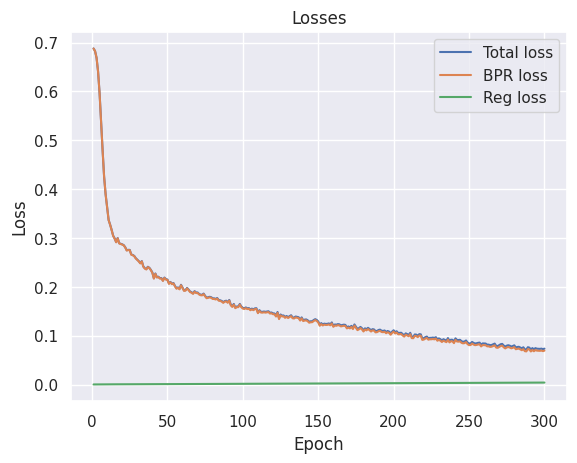

In [25]:
epochs = [(i+1) for i in range(num_epochs)]

sns.set(style='darkgrid')
plt.plot(epochs, total_losses, label='Total loss')
plt.plot(epochs, bpr_losses, label='BPR loss')
plt.plot(epochs, reg_losses, label='Reg loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')

plt.legend()
plt.show()

# Model performance

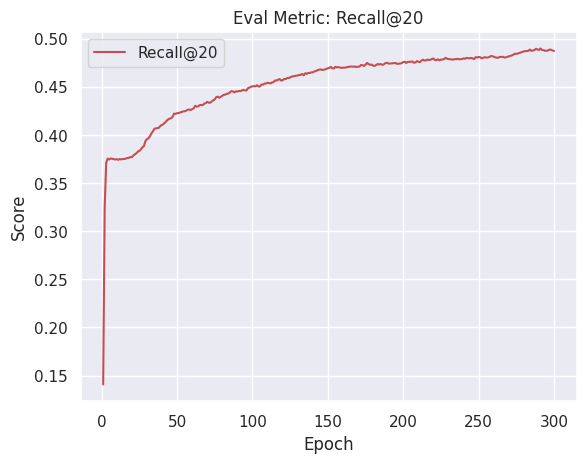

In [26]:
sns.set(style='darkgrid')
plt.plot(epochs, eval_recalls, label='Recall@20', color='r')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Eval Metric: Recall@20')

plt.legend()
plt.show()

In [27]:
print(f'Recall@20: {max(eval_recalls):.3f}')

Recall@20: 0.490


# Make recommendations for a given user

In [28]:
def make_prediction(user_id, model, K):
    model.eval()

    with torch.no_grad():
        _, out = model(edge_index)
        final_user_embed, final_item_embed = torch.split(out, (num_users, num_items))
        user_embed = final_user_embed[user_id]
        item_embeds = final_item_embed

        scores = torch.matmul(user_embed, torch.transpose(item_embeds, 0, 1))
        topk_scores, topk_indices = torch.topk(scores, K)

        data = []
        for i in range(len(topk_indices)):
            item_id = topk_indices[i].cpu().numpy()
            # Retrieve the item name by item id
            item_name = item_names_and_ids[item_names_and_ids['item_id'] == item_id]['item'].values[0]
            item_name = [word.capitalize() for word in item_name.split('-')]
            item_name = " ".join(item_name)

            data.append([i+1, item_id, item_name])

        # Create a DataFrame with the recommended items
        recommendation_ds = pd.DataFrame(data, columns=['Item number', 'Item id', 'Item name'])

        # Print the top K recommended items for the user
        print(f'Top {K} recommended items for user with id: {user_id}')
        print(recommendation_ds.to_string(index=False))

In [29]:
user_id = 1
K = 10

make_prediction(user_id, model, K)

Top 10 recommended items for user with id: 1
 Item number Item id                                                                          Item name
           1     278                                             Lagavulin 12 Year 2022 Special Release
           2     424                                                      Sazerac Rye 18 Year Fall 2016
           3      20                                            Ardbeg Traigh Bhan 19 Year 2019 Edition
           4     251                                                                 J P Wiser S Legacy
           5     211                                                                    Glenmorangie 18
           6      17                                              Appleton Estate Joy Anniversary Blend
           7     228 Heaven Hill 20 Year Heritage Collection Kentucky Straight Corn Whiskey Spring 2023
           8     273                                            Knob Creek 15 Year Bourbon 2021 Release
           9     25

In [30]:
user_id = 400
K = 20

make_prediction(user_id, model, K)

Top 20 recommended items for user with id: 400
 Item number Item id                                                   Item name
           1     407                                           Redbreast 27 Year
           2     161                Elijah Craig Barrel Proof Bourbon Batch A123
           3     151                    Eagle Rare 17 Year Old Bourbon Fall 2014
           4      23 Arran The Devil S Punchbowl Chapter Iii The Fiendish Finale
           5     344                   Middle West Spirits Dark Pumpernickel Rye
           6     467                            The Macallan Double Cask 15 Year
           7     237                                            Highland Park 18
           8     482                                  Uncle Nearest Master Blend
           9     238                                       Highland Park 21 Year
          10      62                           Booker S 25th Anniversary Bourbon
          11      64           Booker S Bourbon Batch 2016 01 

# References

[1] He, Deng et. al., “LightGCN: Simplifying and powering graph convolution network for recommendation.” Proceedings of the 43rd International ACM SIGIR Conference on Research and Development in Information Retrieval. 2020. [Online]. Available: [https://arxiv.org/pdf/2002.02126.pdf](https://arxiv.org/pdf/2002.02126.pdf)

[2] Rendle, Freudenthaler, Gantner and Schmidt-Thieme, "BPR: Bayesian Personalized Ranking from Implicit Feedback". UAI 2009. [Online]. Available:[https://arxiv.org/ftp/arxiv/papers/1205/1205.2618.pdf](https://arxiv.org/ftp/arxiv/papers/1205/1205.2618.pdf)

